# Drift Tubes Digi Occupancy Anomaly Problem

In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

rng = np.random.RandomState(42)

Load occupancy data to the dataframe

In [2]:
runs = [273158, 273730, 274388, 274422, 274968, 274969, 275310, 275311,
        275847, 275890, 276244, 276283, 276384, 276587, 276775, 276776,
        276950, 278509, 278820, 278822, 279694, 279766, 279794, 280018,
        281693, 281727, 281976, 282735, 282814, 276582, 272011, 272012,
        272014, 272017, 272021, 272774, 284044, 284043, 284042, 284041]

drift_tubes_layers = pd.DataFrame()

for run in runs:
    path = "../data/%s.json" % run
    drift_tubes_layers = drift_tubes_layers.append(pd.read_json(path), ignore_index=True);

Append score from labels file

In [3]:
labels_frame = pd.read_csv('../data/labels.csv',
                           names=['wheel', 'station', 'sector', 'run', 'layer', 'score'])

def apply_score(layer):
    score = labels_frame[(labels_frame.wheel == layer.wheel) &
                         (labels_frame.station == layer.station) &
                         (labels_frame.sector == layer.sector) &
                         (labels_frame.run == layer.run) &
                         (labels_frame.layer == layer.layer)].score.values
    if not len(score):
        return np.nan
    return score[0]

drift_tubes_layers['score'] = drift_tubes_layers.apply(apply_score, axis=1);

Use the supervised approach

In [4]:
drift_tubes_layers = drift_tubes_layers[~np.isnan(drift_tubes_layers.score)]

Rescale and reshape the samples

In [5]:
def smooth_reshape_occupancy(layer):
    target_size = 47
    layer = np.array(eval(layer)) 
    Y = []
    stop = 0
    step = len(layer)/float(target_size)

    for i in range(target_size):
        hook = math.floor(stop)
        stop = step + stop
        mean = np.median(layer[int(hook) : int(math.ceil(stop))])
        Y.append(mean)
    return Y

def scale_occupancy(layer):
    denominator = np.max(layer)
    if denominator:
        return layer/denominator
    return layer

drift_tubes_layers['content'] = drift_tubes_layers['content'].apply(smooth_reshape_occupancy)
drift_tubes_layers['content'] = drift_tubes_layers['content'].apply(scale_occupancy)

Split the dataset

In [6]:
drift_tubes_layers['score'] = -(2*drift_tubes_layers['score']-1)

In [7]:
anomalies = drift_tubes_layers[drift_tubes_layers.score == 1]
normalies = drift_tubes_layers[drift_tubes_layers.score == -1]
print("%s faults and %s good samples. In total: %s." %
      (len(anomalies), len(normalies), len(anomalies) + len(normalies)))

anomalies_train, anomalies_test = train_test_split(anomalies, test_size = 0.2, random_state=rng)
normalies_train, normalies_test = train_test_split(normalies, test_size = 0.2, random_state=rng)

layers_train = pd.concat([anomalies_train, normalies_train])
layers_test = pd.concat([anomalies_test, normalies_test])

509 faults and 4659 good samples. In total: 5168.


Train and test the CNN:

In [8]:
import tensorflow as tf
sess = tf.Session()

from keras import backend as K
K.set_session(sess)

import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Reshape, Conv1D, MaxPooling1D, InputLayer

Using TensorFlow backend.


In [9]:
def cnn_generate_input():
    train_x = []
    train_y = []
    test_x = []

    for _, row in layers_train.iterrows():
        train_x.append(np.asarray(row.content))
        if (row.score == -1):
            train_y.append(np.asarray([1, 0]))
        else:
            train_y.append(np.asarray([0, 1]))
        
    for _, row in layers_test.iterrows():
        test_x.append(np.asarray(row.content))

    return train_x, train_y, test_x

In [10]:
def build_cnn():
    model = Sequential()
    model.add(InputLayer((47,), name='input'))
    model.add(Reshape((-1, 47,), input_shape=(47,)))
    model.add(Conv1D(5, 5, strides=1, padding='same', activation='relu', input_shape=(47,)))
    model.add(MaxPooling1D(pool_size=5, strides=5, padding='same'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, activation='softmax', name='output'))
    return model

def train_cnn(model, x, y, batch_size, class_weight):
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer='Nadam')
    model.fit(x, y, batch_size=batch_size, epochs=1000, verbose=0, class_weight=class_weight)
    return model

In [11]:
train_x, train_y, test_x = cnn_generate_input()
model = build_cnn()
classes_count = sum(train_y)
class_weight = {0: classes_count[1], 1: classes_count[0]}
model = train_cnn(model, np.array(train_x), np.array(train_y), len(train_x), class_weight)

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 47)                0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 47)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 5)              1180      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 5)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               768       
_________________________________________________________________
output (Dense)               (None, 2)                 258       
Total para

In [13]:
print(model.inputs)
print(model.output)

[<tf.Tensor 'input:0' shape=(?, 47) dtype=float32>]
Tensor("output/Softmax:0", shape=(?, 2), dtype=float32)


In [14]:
builder = tf.saved_model.builder.SavedModelBuilder("../model")
builder.add_meta_graph_and_variables(sess, [tf.saved_model.tag_constants.SERVING])
builder.save()

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ../model/saved_model.pb


'../model/saved_model.pb'

In [15]:
layers_test['model_score'] = model.predict(np.array(test_x))[:, 1]

This is how the ROC curve for the model looks like:

In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix

def benchmark(y_true, y_score):
    y_pred = 2*(y_score > 0.5)-1
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = round(float(tp)/(tp+fn), 4)
    specificity = round(float(tn)/(tn+fp), 4)
    print "Model accuracy: ", round(accuracy_score(y_true, y_pred), 4)
    print "Model sensitivity: ", sensitivity
    print "Model specificity: ", specificity
    return sensitivity, specificity
    
sensitivity, specificity = benchmark(layers_test['score'], layers_test['model_score'])

Model accuracy:  0.9729
Model sensitivity:  0.9902
Model specificity:  0.971


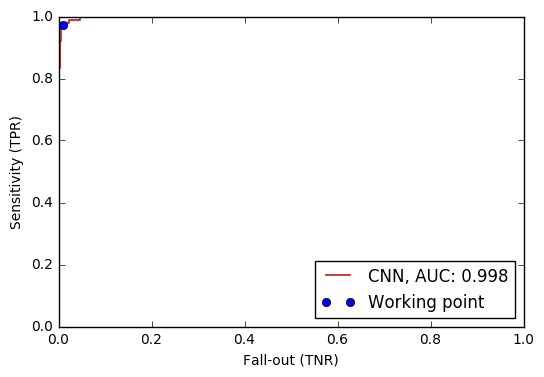

In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def get_roc_curve(score, truth, lines, x, y):
    """Generates ROC Curves for a given array"""
    for color, label in lines:
        false_positive_rate, true_positive_rate, _ = roc_curve(truth, score)

        plt.plot(false_positive_rate, true_positive_rate, color, linewidth=1.2,
                 label=('%s, AUC: %s' % (label, round(auc(false_positive_rate, true_positive_rate), 3))))
                 
    plt.plot(1-x, y, 'bo', label="Working point")
    
    plt.legend(loc='lower right')
    plt.ylabel('Sensitivity (TPR)')
    plt.xlabel('Fall-out (TNR)')
    
    plt.show();
    
get_roc_curve(layers_test['model_score'], layers_test['score'], [('#b71c1c', 'CNN')], sensitivity, specificity)

And this is distribution of scores:

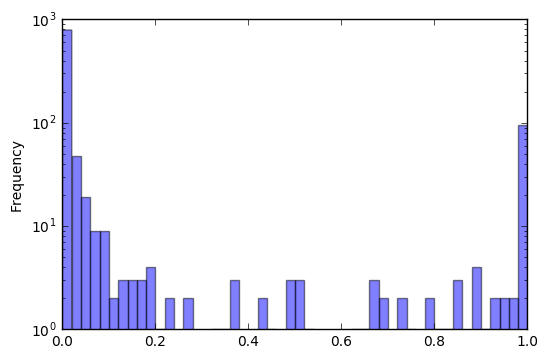

In [18]:
layers_test['model_score'].plot.hist(alpha=0.5, bins=50, logy=True)
plt.show();